<a href="https://colab.research.google.com/github/mhuertascompany/DL_ED127_2021/blob/main/hand-on/day2/solutions/Galaxy_Morphology_ANN_ED127_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Galaxy Morphology with ANNs

The goal of this tutorial is to illustrate a very basic supervised binary classification with different ML approaches. The goal is to setup a ML algorithm to determine the visual morphological type of nearby galaxies from the Sloan Digital Sky Survey. The first deep learning papers in Astronomy addressed this problem at low and high redshift (Dielemann+15, Huertas-Company+15).

![](https://drive.google.com/uc?id=1TaiRB1wxui4AKnhuF4iH4LJkmrlb-D6d)

This first notebook illustrates how to train an Artifical Neural Network using catalog parameters (Stellar Mass and Color). The ML models are taken from scikitlearn.



---



#### Before we start, make sure to open this Colab notebook in "PlayGround Mode" (top left) and to change the Runtime type to GPU by navigating to the toolbar and clicking Runtime -> Change runtime type and then changing Hardware accelerator to GPU

---

In [ ]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import os
from sklearn import preprocessing


from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten



from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score,auc
import tensorflow.compat.v2 as tf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Mount Drive

Before mounting the drive click on [this folder](https://drive.google.com/drive/folders/1PcftgBzBySo1Ync-Wdsp9arTCJ_MfEPE?usp=sharing) and add it to your google drive by following these steps:

*   Go to your drive 
*   Find shared folder ("Shared with me" link)
*   Right click it
*   Click Add to My Drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
#### The notenook is setup to illustrate 2 different classifications:


#### 1.   Early vs. Late: This is an easy example in which we only try to separate between early-type and late-type galaxies.

#### 2.   E vs. S0: The second example is more challenging. We try to separate ellipticals from S0s.

#### By default case 1 is turn on. In order to switch to case 2 set the variable CLASS_EARLY_LATE to False.

---





In [ ]:
CLASS_EARLY_LATE=True

## Classical ML (ANN)

### Load data and prepare data

For the classical approaches, the input are catalog parameters (color, mass for illustration) which correlate with galaxy morphology. It is well known that early type galaxies are redder and more massive than late type galaxies. So we are going to exploit these correlation to estimate the galaxy morphology.

In [ ]:
pathinData="/content/drive/My Drive/ED127_2021/morphology"

if CLASS_EARLY_LATE:
  # donwload feature vector and labels
  X_ML = np.load(pathinData+'/feature_E_S.npy')
  #morphological class
  Y_ML = np.load(pathinData+'/label_E_S.npy') 
  #we also load images (for visualization purposes - not used for training)
  I_ML=np.load(pathinData+'/images_ML.npy') 

  

else:
  # donwload feature vector and labels
  X_ML = np.load(pathinData+'/feature_E_S0.npy')
  #morphological class
  Y_ML = np.load(pathinData+'/label_E_S0.npy') 
  #we also load images (for visualization purposes - not used for training)
  I_ML=np.load(pathinData+'/images_ML_E_S0.npy') 
  
#split training and test datasets
X_ML_train = X_ML[0:len(X_ML)//5*4,:]   
X_ML_test = X_ML[len(X_ML)//5*4:,:]
Y_ML_train = Y_ML[0:len(Y_ML)//5*4]
Y_ML_test = Y_ML[len(Y_ML)//5*4:]
I_ML_train = I_ML[0:len(I_ML)//5*4,:,:,:]
I_ML_test = I_ML[len(Y_ML)//5*4:,:,:,:]


### Visualize some images for illustration

In [ ]:
randomized_inds_train = np.random.permutation(len(I_ML))

fig = plt.figure()
for i,j in zip(randomized_inds_train[0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(I_ML[i,:,:].astype(int))
  plt.title('$Morph$='+str(Y_ML[i]))
  fig.tight_layout() 
  fig.colorbar(im)


### Visualize the feature space used for classification (Stellar Mass / Color)

For the classical ML classification we are going to use 2 catalog parameters only (stellar mass and color). This means that all the information contained in the images is reduced to 2 parameters (features) which is what the algorithms see and will use for classification. The following cell plots these parameters for both classes. The two different classes are expected to have different distributions in the feature space so that the ML algorithm can partition the space.

In [ ]:
xlabel("$Log(M_*)$", fontsize=20)
ylabel("g-r", fontsize=20)
xlim(8,12)
ylim(0,1.2)
scatter(X_ML[Y_ML==1,1],X_ML[Y_ML==1,0],color='blue',s=1,label='Morph1')
scatter(X_ML[Y_ML==0,1],X_ML[Y_ML==0,0],color='red',s=1,label='Morph0')
legend(fontsize=14)

### Train ANN
The second "classical" algorithm we test is an Artificial Neural Network which again takes as input 2 parameters. We use here an architecture with only one hdden layer. This can also be changed to explore the effects.

The following cell is used to launch TensorBoard which should enable you to visualize the training. Just run the cell. You should see an orange panel appearing. You will need Google Chrome for this to work. If it does not appear, just continue running the other cells. This will not affect the other cells.

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir morphology/models/ann

The following cell trains the ANN. If the previous cell worked, you should see some plots appearing in the window above showing the learning history.

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import  BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D

pathout='morphology/models/ann' #output folder to store the results
model_name = '/ann1'  #name of the final model which is saved in pathout


# this is to delete ALL previous runs. Only set to True if you want to remove them.
RESET=True
if RESET:
  print("deleting")
  os.system("rm -r "+pathout)

# some hyperparamters to be changed
nb_epoch=15
batch_size=50

#Define callbacks to avoid more iterations once convergence
patience_par=10
#earlystopping = EarlyStopping(monitor='val_loss',patience = patience_par,verbose=0,mode='auto' )
#modelcheckpoint = ModelCheckpoint(pathout+model_name+"_best.hd5",monitor='val_loss',verbose=0,save_best_only=True)
tensorboard = TensorBoard(log_dir=pathout)


ann = Sequential()
ann.add(Flatten(input_shape=(2,1)))  ## this is your input layer. Do not change.
ann.add(Dense(10,activation='relu'))
ann.add(Dense(1,activation="sigmoid"))  ## this is your ouptut layer (1 value). Do not change.

# compilation of model. loss defintion. we are using binary crossentropy.
ann.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# train the model. YOU CAN CHANGE BATCH SIZE AND NB_EPOCHS TO EXPLORE THE EFFECTS 
Xexp=np.expand_dims(X_ML_train,2)
print(Xexp.shape)
ann.fit(Xexp,Y_ML_train,epochs=nb_epoch,batch_size=50,callbacks=[tensorboard])

# save model just in case it is needed
ann.save(pathout+model_name+".hd5")

Plots the learning history

In [ ]:
xlabel("Epochs", fontsize=20)
ylabel("Loss", fontsize=20)
xlim(0,50)
ylim(0,1.2)


plot(history.history['loss'],linewidth=3,color='black')


## Predictions and comparisons of different approaches
The following cells use the trained models (RF,ANN and CNN) to predict the morphological class of the test dataset and compare the performance of the different algorithms. 

In [ ]:
print("Predicting...")
print("====================")

# set to true if you want to load a specific model. otherwise it will just use 
# the last model trained
LOAD_MODEL=False
if LOAD_MODEL:
  ann = tf.keras.models.load_model(pathout+model_name+".hd5")


## This line uses the trained model to predict
Y_pred_ANN=ann.predict(np.expand_dims(X_ML_test,2))



We now compute the global accuracy as well as ROC and P-R curves. Use the code fromt yesterday's notebook.

In [ ]:
# objects classifed as early-types by the ANN but visually classifed as late-types
bad = np.where((Y_pred_ANN[:,0]<0.5)&(Y_ML_test==1))
randomized_inds_train = np.random.permutation(bad)

fig = plt.figure()
fig.suptitle("Galaxies visually classifed as Class1 but classified as Class0",fontsize=10)
for i,j in zip(randomized_inds_train[0][0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(I_ML_test[i,:,:])
  plt.title('$Morph$='+str(Y_ML_test[i]))
  fig.tight_layout() 
  fig.colorbar(im)



# objects classifed as late-types by the ANN but visually classifed as early-types
bad2 = np.where((Y_pred_ANN[:,0]>0.5)&(Y_ML_test==0))
randomized_inds_train = np.random.permutation(bad2)

fig = plt.figure()
fig.suptitle("Galaxies visually classifed as Class0 but classified as Class1",fontsize=10)
for i,j in zip(randomized_inds_train[0][0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(I_ML_test[i,:,:])
  plt.title('$Morph$='+str(Y_ML_test[i]))
  fig.tight_layout() 
  fig.colorbar(im)
  
#visualize the feature space
fig = plt.figure()
xlabel("$Log(M_*)$", fontsize=20)
ylabel("g-r", fontsize=20)
xlim(8,12)
ylim(0,1.2)
scatter(X_ML_test[bad[0],1],X_ML_test[bad[0],0],color='pink',s=25,label="S class. as E")
scatter(X_ML_test[bad2[0],1],X_ML_test[bad2[0],0],color='orange',s=25,label='E class. as S') 
legend(fontsize=14)

The follwing cells visualize some random examples of bad classifications in order to explore what the network has understood. If you run multiple times the examples will change.

RUN FIRST WITH VERY SIMPLE NN MODEL AND THEN INCREASE THE NUMBER OF HIDDEN LAYERS AND OBSERVE THE BEHAVIOUR OF MISS-CLASSIFICATIONS. COMMENT.

### Bad classifications of ANNs

In [ ]:
# objects classifed as early-types by the ANN but visually classifed as late-types
bad = np.where((Y_pred_ANN[:,0]<0.5)&(Y_ML_test==1))
randomized_inds_train = np.random.permutation(bad)

fig = plt.figure()
fig.suptitle("Galaxies visually classifed as Class1 but classified as Class0",fontsize=10)
for i,j in zip(randomized_inds_train[0][0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(I_ML_test[i,:,:])
  plt.title('$Morph$='+str(Y_ML_test[i]))
  fig.tight_layout() 
  fig.colorbar(im)



# objects classifed as late-types by the ANN but visually classifed as early-types
bad2 = np.where((Y_pred_ANN[:,0]>0.5)&(Y_ML_test==0))
randomized_inds_train = np.random.permutation(bad2)

fig = plt.figure()
fig.suptitle("Galaxies visually classifed as Class0 but classified as Class1",fontsize=10)
for i,j in zip(randomized_inds_train[0][0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(I_ML_test[i,:,:])
  plt.title('$Morph$='+str(Y_ML_test[i]))
  fig.tight_layout() 
  fig.colorbar(im)
  
#visualize the feature space
fig = plt.figure()
xlabel("$Log(M_*)$", fontsize=20)
ylabel("g-r", fontsize=20)
xlim(8,12)
ylim(0,1.2)
scatter(X_ML_test[bad[0],1],X_ML_test[bad[0],0],color='pink',s=25,label="S class. as E")
scatter(X_ML_test[bad2[0],1],X_ML_test[bad2[0],0],color='orange',s=25,label='E class. as S') 
legend(fontsize=14)

## ANN Classifier E/S0

Repeat the steps above for the E/S0 classification. Plot in the same figure the ROC and P-R curves for the two cases. Comment the results.

In [ ]:
CLASS_EARLY_LATE=False

## Increasing the number of parameters

In the previous sections we have used only 2 parameters to perform the classification. We will try now to use more dimensions. The following cell loads a catalog with 5 parameters: stellar mass, color, Sersic Index, Velocity Dispersion and axis ratio. Repeat the steps above with different sets of parameters, compare and comment. Compare with RFs. Are there any differences? Comment. YOU MIGHT NEED TO RESET THE RUNTIME FOR THIS TO WORK. GO TO MENU RUNTIME, SELECT "FACTORY RESET RUNTIME" AND RUN AGAIN THIS CELL WITHOUT LOADING THE FIRST DATASET.

In [ ]:
pathinData="/content/drive/My Drive/ED127_2021/morphology"

if CLASS_EARLY_LATE:
  # donwload feature vector and labels
  X_ML = np.load(pathinData+'/feature_E_S_large.npy')
  #morphological class
  Y_ML = np.load(pathinData+'/label_E_S_large.npy') 
  #we also load images (for visualization purposes - not used for training)
  I_ML=np.load(pathinData+'/images_ML_E_S_large.npy') 

  

else:
  # donwload feature vector and labels
  X_ML = np.load(pathinData+'/feature_E_S0_large.npy')
  #morphological class
  Y_ML = np.load(pathinData+'/label_E_S0_large.npy') 
  #we also load images (for visualization purposes - not used for training)
  I_ML=np.load(pathinData+'/images_ML_E_S0_large.npy') 
  
#split training and test datasets
X_ML_train = X_ML[0:len(X_ML)//5*4,:]   
X_ML_test = X_ML[len(X_ML)//5*4:,:]
Y_ML_train = Y_ML[0:len(Y_ML)//5*4]
Y_ML_test = Y_ML[len(Y_ML)//5*4:]
I_ML_train = I_ML[0:len(I_ML)//5*4,:,:,:]
I_ML_test = I_ML[len(Y_ML)//5*4:,:,:,:]

## Probabilisitc Modeling

Can you transform the model into a probabilistic model? You can use the following function: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Bernoulli

In [ ]:
import tensorflow_probability as tfp
import keras
num_components = 1
event_shape = [1]

params_size = tfp.layers.MixtureSameFamily.params_size(
    num_components,
    component_params_size=tfp.layers.IndependentBernoulli.params_size(event_shape))



model = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(5,)),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=params_size, activation=None),
    tfp.layers.MixtureSameFamily(num_components, tfp.layers.IndependentBernoulli(event_shape))
])
    #keras.layers.Dense(tfp.layers.MixtureNormal.params_size(num_components, event_shape)),
    #tfp.layers.MixtureNormal(num_components, event_shape)
    #keras.layers.Dense(units=num_components*3),
    #tfp.layers.DistributionLambda(lambda t: tfd.Independent(
     #   tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=tf.expand_dims(t[..., :num_components], -2)),
      #                        components_distribution=tfd.Beta(1 + tf.nn.softplus(tf.expand_dims(t[..., num_components:2*num_components], -2)),
       #                                                        1 + tf.nn.softplus(tf.expand_dims(t[..., 2*num_components:],-2)))), 1))
    

negloglik = lambda y, p_y: -p_y.log_prob(y)

callback = tf.keras.callbacks.LearningRateScheduler(lambda e: 0.001 if e < 5 else 0.0001)

model.compile(loss=negloglik, optimizer='adam', metrics=[])

In [ ]:
print(Y_ML.shape)

(11489,)


In [ ]:
#Xexp=np.expand_dims(X_ML_train,2)
#print(Xexp.shape)

##you can run several models 
history=model.fit(X_ML_train,Y_ML_train,epochs=50)

Epoch 1/50
288/288 [==============================] - 4s 2ms/step - loss: 1.0648
Epoch 2/50
288/288 [==============================] - 1s 2ms/step - loss: 0.4907
Epoch 3/50
288/288 [==============================] - 1s 2ms/step - loss: 0.5277
Epoch 4/50
288/288 [==============================] - 1s 2ms/step - loss: 0.5096
Epoch 5/50
288/288 [==============================] - 1s 2ms/step - loss: 0.4839
Epoch 6/50
288/288 [==============================] - 1s 2ms/step - loss: 0.4404
Epoch 7/50
288/288 [==============================] - 1s 2ms/step - loss: 0.4357
Epoch 8/50
288/288 [==============================] - 1s 2ms/step - loss: 0.4615
Epoch 9/50
288/288 [==============================] - 1s 2ms/step - loss: 0.4231
Epoch 10/50
288/288 [==============================] - 1s 2ms/step - loss: 0.4660
Epoch 11/50
288/288 [==============================] - 1s 2ms/step - loss: 0.4351
Epoch 12/50
288/288 [==============================] - 1s 2ms/step - loss: 0.4301
Epoch 13/50
288/288 [====

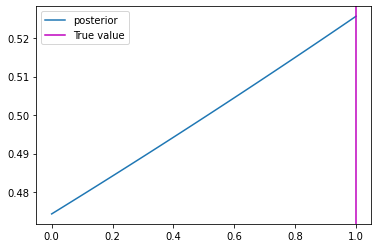

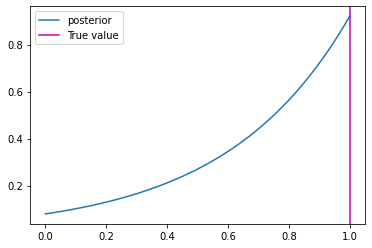

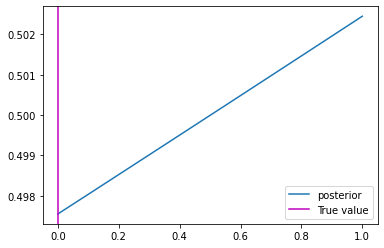

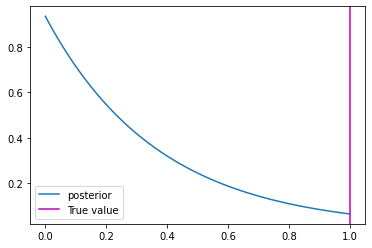

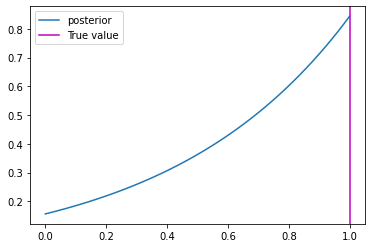

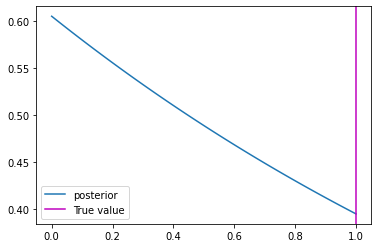

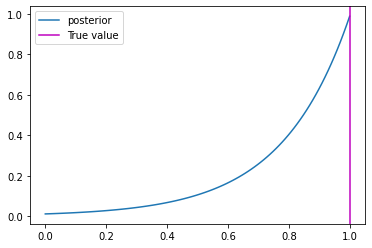

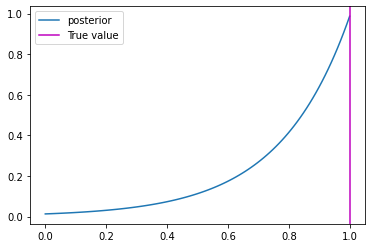

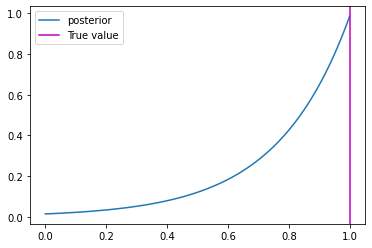

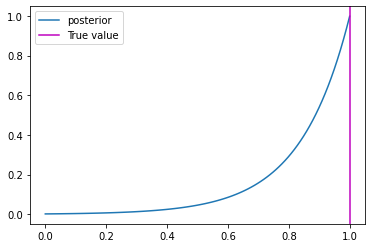

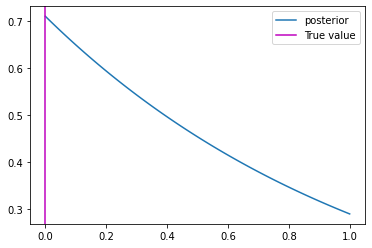

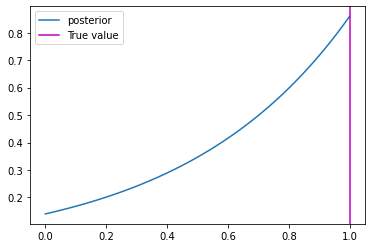

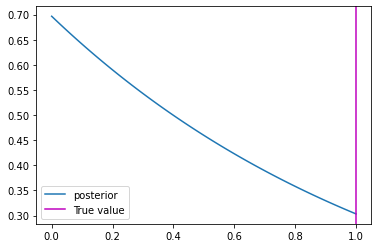

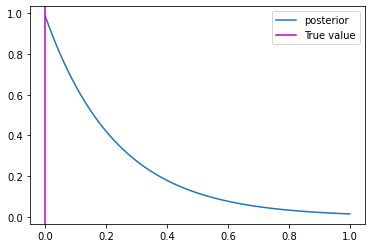

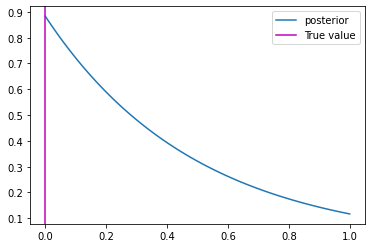

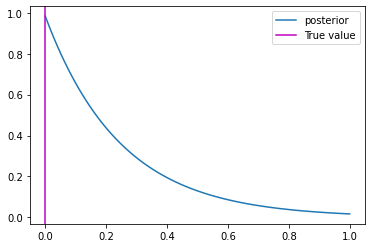

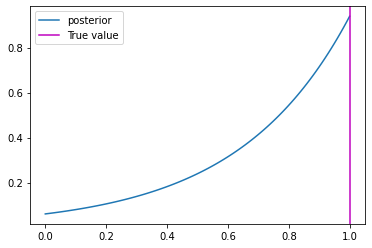

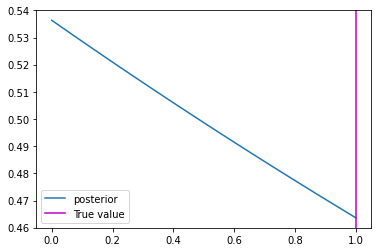

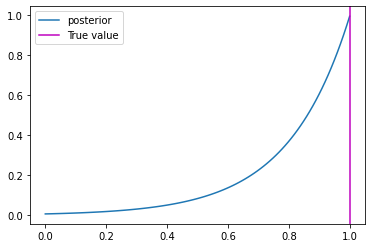

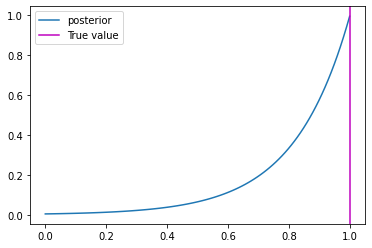

In [ ]:
import pdb
# Let's plot some posterior distributions
x = linspace(0,1,100)
# This returns the distribution q(M | x) for all clusters
outputs = model(X_ML_test)
#xt = scaler.transform(x.reshape((-1,1)))
logps = []

for i in range(len(x)):
    logps.append(outputs.log_prob(x[i]).numpy())
logps = np.stack(logps)

for i in range(20):
  figure()
  plot(x, np.exp(logps[:,-i]), label='posterior')
  #pdb.set_trace()
  axvline(Y_ML_test[-i], color='m', label='True value')
  legend()